In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display
import numpy as np
import librosa
import tensorflow as tf
import glob

In [2]:
drone_path_1 = '../../data/1mtest/*.wav'
drone_path_10 = '../../data/10mtest/*.wav'
drone_path_20 = '../../data/20mtest/*.wav'
drone_path_30 = '../../data/30mtest/*.wav'
drone_path_40 = '../../data/40mtest/*.wav'
drone_path_50 = '../../data/50mtest/*.wav'
background_path = '../../data/backgroundtest/*.wav'

drone_files_1 = glob.glob(drone_path_1)
drone_files_10 = glob.glob(drone_path_10)
drone_files_20 = glob.glob(drone_path_20)
drone_files_30 = glob.glob(drone_path_30)
drone_files_40 = glob.glob(drone_path_40)
drone_files_50 = glob.glob(drone_path_50)
background_files = glob.glob(background_path)

In [3]:
CHUNK_SIZE = 8192
SR = 22050
N_MFCC = 16

In [4]:
def load(files, sr=22050):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
drone_raw_1 = load(drone_files_1)
drone_raw_10 = load(drone_files_10)
drone_raw_20 = load(drone_files_20)
drone_raw_30 = load(drone_files_30)
drone_raw_40 = load(drone_files_40)
drone_raw_50 = load(drone_files_50)

background_raw = load(background_files)

(102400,)
(143360,)
(102400,)
(111258,)
(145839,)
(143360,)
(105693,)


In [6]:
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=22050, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc, n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print(i,">small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0], mfcc_slice.shape[1]))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

In [7]:
mfcc_drone_1, y_drone_1 = mfcc4(drone_raw_1, 0)
mfcc_drone_10, y_drone_10 = mfcc4(drone_raw_10, 1)
mfcc_drone_20, y_drone_20 = mfcc4(drone_raw_20, 2)
mfcc_drone_30, y_drone_30 = mfcc4(drone_raw_30, 3)
mfcc_drone_40, y_drone_40 = mfcc4(drone_raw_40, 4)
mfcc_drone_50, y_drone_50 = mfcc4(drone_raw_50, 5)

mfcc_background, y_background = mfcc4(background_raw, 6)

(102400,)
98304 >small end: (16, 9)
(143360,)
139264 >small end: (16, 9)
(102400,)
98304 >small end: (16, 9)
(111258,)
106496 >small end: (16, 10)
110592 >small end: (16, 2)
(145839,)
139264 >small end: (16, 13)
143360 >small end: (16, 5)
(143360,)
139264 >small end: (16, 9)
(105693,)
98304 >small end: (16, 15)
102400 >small end: (16, 7)


In [8]:
print(mfcc_drone_1.shape, y_drone_1.shape)
print(mfcc_drone_10.shape, y_drone_10.shape)
print(mfcc_drone_20.shape, y_drone_20.shape)
print(mfcc_drone_30.shape, y_drone_30.shape)
print(mfcc_drone_40.shape, y_drone_40.shape)
print(mfcc_drone_50.shape, y_drone_50.shape)
print(mfcc_background.shape, y_background.shape)

(24, 16, 16) (24,)
(34, 16, 16) (34,)
(24, 16, 16) (24,)
(26, 16, 16) (26,)
(34, 16, 16) (34,)
(34, 16, 16) (34,)
(24, 16, 16) (24,)


In [9]:
X = np.concatenate((mfcc_drone_1,mfcc_drone_10,mfcc_drone_20,mfcc_drone_30,mfcc_drone_40,mfcc_drone_50, mfcc_background), axis=0)
y = np.hstack((y_drone_1, y_drone_10, y_drone_20, y_drone_30, y_drone_40, y_drone_50, y_background))
print(X.shape, y.shape)

(200, 16, 16) (200,)


In [10]:
X_test = np.reshape(X,(X.shape[0],-1))
print(X_test.shape)
print(type(X_test))

(200, 256)
<class 'numpy.ndarray'>


In [11]:
#X_train2 = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) ############# 리셰입 해야 

In [12]:
n_labels = y.shape[0]
n_unique_labels = 7
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)

(200, 7)


# test init

In [13]:
tf.reset_default_graph()

In [14]:
n_mfcc = 16
n_frame = 16
n_classes = 7
n_channels = 1

kernel_size = 3
stride = 1
pad = "SAME"

learning_rate = 0.0002

In [15]:
X = tf.placeholder(tf.float32, shape=[None,n_mfcc*n_frame*n_channels])
#X = tf.reshape(X, [-1, n_mfcc, n_frame, n_channels]) #fully connected에는 리셰입 안해도 된다 
Y = tf.placeholder(tf.float32, shape=[None,n_classes])

keep_prob = tf.placeholder(tf.float32)

#dense2 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
#dropout2 = tf.layers.dropout(inputs=dense2, rate=0.5, training=True)
dense1 = tf.layers.dense(inputs=X, units=256, activation=tf.nn.relu)
dropout1 = tf.nn.dropout(dense1, keep_prob=keep_prob)
dense2 = tf.layers.dense(inputs=dropout1, units=256, activation=tf.nn.relu)
dropout2 = tf.nn.dropout(dense2, keep_prob=keep_prob)
dense3 = tf.layers.dense(inputs=dropout2, units=512, activation=tf.nn.relu)
dropout3 = tf.nn.dropout(dense3, keep_prob=keep_prob)
#이거 지워보고 돌려보고 
dense4 = tf.layers.dense(inputs=dropout3, units=512, activation=tf.nn.relu)
dropout4 = tf.nn.dropout(dense4, keep_prob=keep_prob)
dense5 = tf.layers.dense(inputs=dropout4, units=256, activation=tf.nn.relu)
dropout5 = tf.nn.dropout(dense5, keep_prob=keep_prob)

logits= tf.layers.dense(inputs=dropout5, units=7)

In [16]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [17]:
# Model Save
sess=tf.Session()
saver = tf.train.Saver()
saver.restore(sess, '../../model/DNN/7_dense_model')

INFO:tensorflow:Restoring parameters from ../../model/DNN/7_dense_model


In [18]:
# Prediction
y_test = sess.run(tf.nn.softmax(logits), feed_dict={X: X_test, keep_prob:1})
y_pred = sess.run(tf.argmax(logits,1),feed_dict={X: X_test , keep_prob:1}) 
y_true = sess.run(tf.argmax(y_encoded,1))
print(type(y_test))

<class 'numpy.ndarray'>


In [19]:
def conversion(input):
    switcher ={
        0: 1,
        1: 10,
        2: 20,
        3: 30,
        4: 40,
        5: 50,
        6: 100
    }
    return switcher.get(input)

In [20]:
import pandas as pd
pd.options.display.max_rows = 4000
#print(pd.DataFrame(y_test))
resultX = []
resultY = []
predX = []
meanX = []
meanY = []
out_mean = []

# 1m
sum = 0
out_sum = 0
for i in range(0,24):
    cal = round(y_test[i][0]*1+y_test[i][1]*10+y_test[i][2]*20+y_test[i][3]*30+y_test[i][4]*40+y_test[i][5]*50+y_test[i][6]*100,2)
    sum += cal
    resultX.append(cal)
    resultY.append(1)
    
    out = int(conversion(y_pred[i]))
    predX.append(out)
    out_sum += out

meanX.append(sum/24)
meanY.append(1)
out_mean.append(out_sum/24)
sum = 0
out_sum = 0

# 10m
for i in range(34,58):
    cal = round(y_test[i][0]*1+y_test[i][1]*10+y_test[i][2]*20+y_test[i][3]*30+y_test[i][4]*40+y_test[i][5]*50+y_test[i][6]*100,2)
    sum += cal
    resultX.append(cal)
    resultY.append(10)
    
    out = int(conversion(y_pred[i]))
    predX.append(out)
    out_sum += out

meanX.append(sum/24)
meanY.append(10)
out_mean.append(out_sum/24)
sum = 0
out_sum = 0

# 20m
for i in range(58,82):
    cal = round(y_test[i][0]*1+y_test[i][1]*10+y_test[i][2]*20+y_test[i][3]*30+y_test[i][4]*40+y_test[i][5]*50+y_test[i][6]*100,2)
    sum += cal
    resultX.append(cal)
    resultY.append(20)
    
    out = int(conversion(y_pred[i]))
    predX.append(out)
    out_sum += out

meanX.append(sum/24)
meanY.append(20)
out_mean.append(out_sum/24)
sum = 0
out_sum = 0

# 30m
for i in range(82,106):
    cal = round(y_test[i][0]*1+y_test[i][1]*10+y_test[i][2]*20+y_test[i][3]*30+y_test[i][4]*40+y_test[i][5]*50+y_test[i][6]*100,2)
    sum += cal
    resultX.append(cal)
    resultY.append(30)
    
    out = int(conversion(y_pred[i]))
    predX.append(out)
    out_sum += out

meanX.append(sum/24)
meanY.append(30)
out_mean.append(out_sum/24)
sum = 0
out_sum = 0

# 40m
for i in range(108,132):
    cal = round(y_test[i][0]*1+y_test[i][1]*10+y_test[i][2]*20+y_test[i][3]*30+y_test[i][4]*40+y_test[i][5]*50+y_test[i][6]*100,2)
    sum += cal
    resultX.append(cal)
    resultY.append(40)
    
    out = int(conversion(y_pred[i]))
    predX.append(out)
    out_sum += out

meanX.append(sum/24)
meanY.append(40)
out_mean.append(out_sum/24)
sum = 0
out_sum = 0

# 50m
for i in range(142,166):
    cal = round(y_test[i][0]*1+y_test[i][1]*10+y_test[i][2]*20+y_test[i][3]*30+y_test[i][4]*40+y_test[i][5]*50+y_test[i][6]*100,2)
    sum += cal
    resultX.append(cal)
    resultY.append(50)
    
    out = int(conversion(y_pred[i]))
    predX.append(out)
    out_sum += out

meanX.append(sum/24)
meanY.append(50)
out_mean.append(out_sum/24)

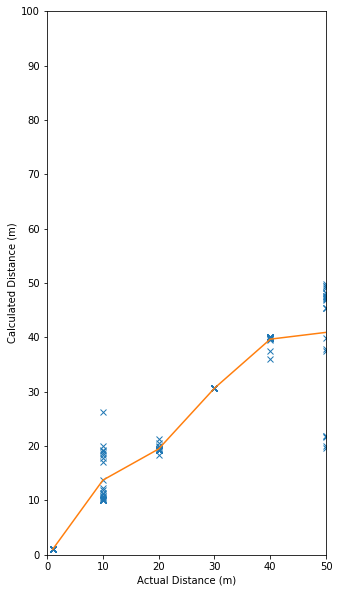

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

fig= plt.figure(figsize=(5,10))
axes= fig.add_subplot(111)

plt.ylim(0, 100)
plt.xlim(0,50)
axes.plot(resultY, resultX,'x')
plt.xlabel('Actual Distance (m)')
plt.ylabel('Calculated Distance (m)')
axes.plot(meanY, meanX)

axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100])

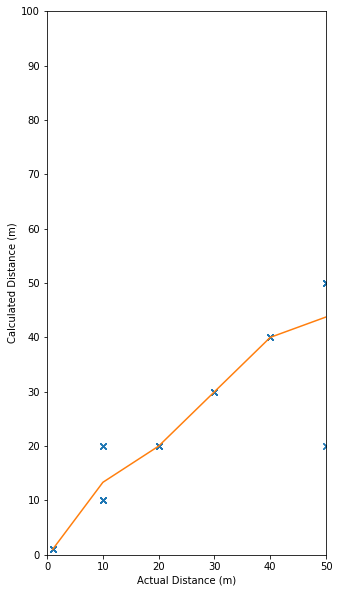

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

fig= plt.figure(figsize=(5,10))
axes= fig.add_subplot(111)

plt.ylim(0, 100)
plt.xlim(0,50)
plt.xlabel('Actual Distance (m)')
plt.ylabel('Calculated Distance (m)')
axes.plot(resultY,predX,'x')
axes.plot(meanY, out_mean)

axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100])

In [23]:
print('mean : ', meanX)
print('out_mean: ', out_mean)

mean :  [1.0, 13.733333333333329, 19.472083333333334, 30.649999999999988, 39.67000000000001, 40.91875]
out_mean:  [1.0, 13.333333333333334, 20.0, 30.0, 40.0, 43.75]


F-Score: 0.9
Accuracy:  0.905
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      0.71      0.83        34
           2       0.56      1.00      0.72        24
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        34
           5       1.00      0.82      0.90        34
           6       1.00      0.88      0.93        24

   micro avg       0.91      0.91      0.91       200
   macro avg       0.94      0.91      0.91       200
weighted avg       0.95      0.91      0.91       200

[[24  0  0  0  0  0  0]
 [ 0 24 10  0  0  0  0]
 [ 0  0 24  0  0  0  0]
 [ 0  0  0 26  0  0  0]
 [ 0  0  0  0 34  0  0]
 [ 0  0  6  0  0 28  0]
 [ 0  0  3  0  0  0 21]]


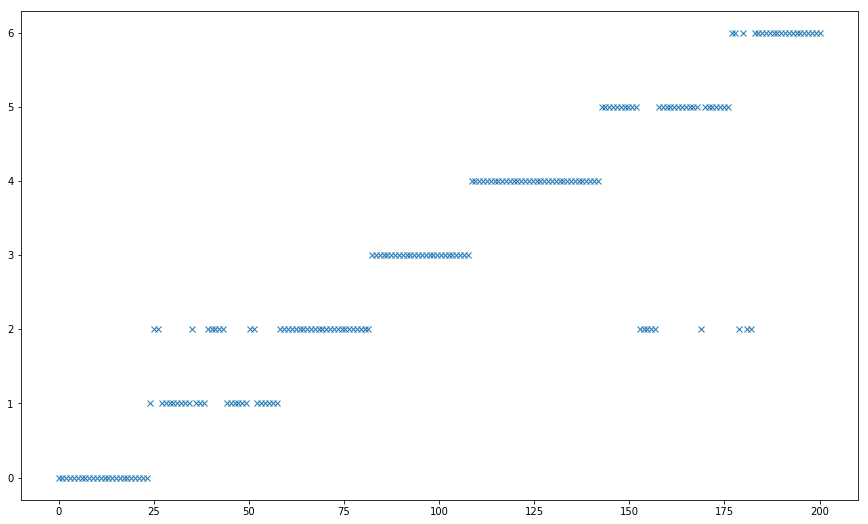

In [24]:
# Print Result

from sklearn.metrics import precision_recall_fscore_support
y_true = y_true
y_pred = y_pred

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,2))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))


#fig = plt.figure(figsize=(15,9))
#ax = fig.add_subplot(1,1,1)
#ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_true, 'x')


fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_pred, 'x')

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

# Graph